*** Module 3: Waves ***

# Sods Shock tube, Richtmyer method #

In [252]:
import numpy
from matplotlib import pyplot
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16

import sympy
from sympy import init_printing
init_printing()
from sympy.utilities.lambdify import lambdify

In [253]:
def vector_u(rho,u,p):
    # there is a little problem because the name of the vector is the same as the name of the velocity variable 
    #we change it into vector_u but it is a bit cumbersome
    #v=numpy.zeros((3,len(rho)))
    v=numpy.array([rho,rho*u,rho*(p/(0.4*rho)+0.5*(u)**2)])
    return v

$$\underline{\mathbf{f}} = \left[ \begin{array}{c}
f_1 \\
f_2 \\
f_3 \\ \end{array} \right] =
\left[ \begin{array}{c}
u_2\\
\frac{u^2_2}{u_1} + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1} \right) \\
\left(u_3 + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1}\right) \right) \frac{u_2}{u_1}\\ \end{array}
\right]$$

In [254]:
def computef(uv):
    # We define f as a function of u
    f=numpy.zeros_like((uv))
    f[0]=uv[1]
    f[1]=uv[1]**2/uv[0]+0.4*(uv[2]-0.5*uv[1]**2/uv[0])
    f[2]=(uv[1]/uv[0])*(uv[2]+0.4*(uv[2]-0.5*uv[1]**2/uv[0]))
    return f

In [255]:
dx= 0.25 #meter
dt=0.0002 #second
nx=81 #so that we cover 20 km, from -10 to +10

In [256]:
x=numpy.linspace(-10,10,nx)

In [257]:
IC=numpy.zeros((3,nx))
IC[0,:40]=1.0 #kg/m³
IC[0,40:]=0.125 #kg/m³
IC[1,0:]=0.0 #m/s
IC[2,:40]=100000.0 #N/m²
IC[2,40:]=10000.0 #N/m²

\begin{align}
\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} &= \frac{1}{2} \left( \underline{\mathbf{u}}^n_{i+1} + \underline{\mathbf{u}}^n_i \right) - 
\frac{\Delta t}{2 \Delta x} \left( \underline{\mathbf{f}}^n_{i+1} - \underline{\mathbf{f}}^n_i\right) \\
\underline{\mathbf{u}}^{n+1}_i &= \underline{\mathbf{u}}^n_i - \frac{\Delta t}{\Delta x} \left(\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} - \underline{\mathbf{f}}^{n+\frac{1}{2}}_{i-\frac{1}{2}} \right)
\end{align}

In [258]:
def Shock(v0,nt):
    uu=v0.copy()
    predictor=numpy.zeros((3,80))
    for t in range(nt):
        
        vv=uu.copy()
        f=computef(uu)
        predictor[:,:]=0.5*(uu[:,1:]+uu[:,:-1])-0.5*dt/dx*(f[:,1:]-f[:,:-1])
        ff=computef(predictor)
        vv[:,1:-1]=uu[:,1:-1]-dt/dx*(ff[:,1:]-ff[:,:-1])
        uu=vv.copy()
        
    return uu

In [259]:
v0=vector_u(IC[0],IC[1],IC[2])
shock=Shock(v0,50)

In [260]:
def ans(j,vector):
    v=numpy.ones(3)
    v[0]=vector[0,j]
    v[1]=vector[1,j]/vector[0,j]
    v[2]=0.4*(vector[2,j]-0.5*vector[1,j]**2/vector[0,j])
    return v

In [261]:
def plot(vector):
    #we create a function that will give us directly the density, the velocity and the pressure as a vector
    v=numpy.ones((3,81))
    for j in range(81):
            v[:,j]=ans(j,vector)
    return v

In [262]:
def graph(ordonnée,ymin,ymax,title):
    pyplot.plot(x,ordonnée, color='#003366', lw=1)
    pyplot.ylim(ymin,ymax);
    pyplot.xlabel('x (km)', fontsize=14) #x label
    pyplot.ylabel(title, fontsize=14) #y label,
    pyplot.title(title, y=1.08, fontsize=15) ;

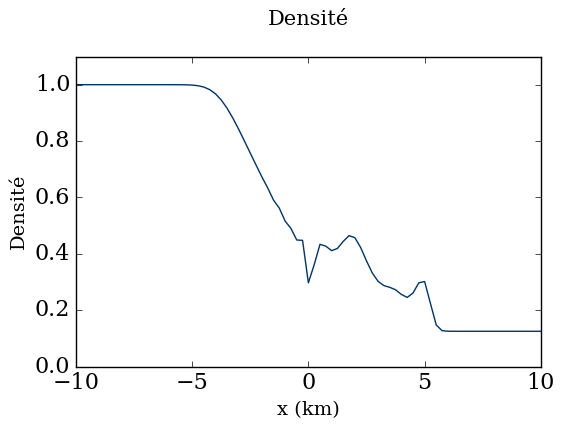

In [263]:
graph(plot(shock)[0],0.0,1.1,'Densité')

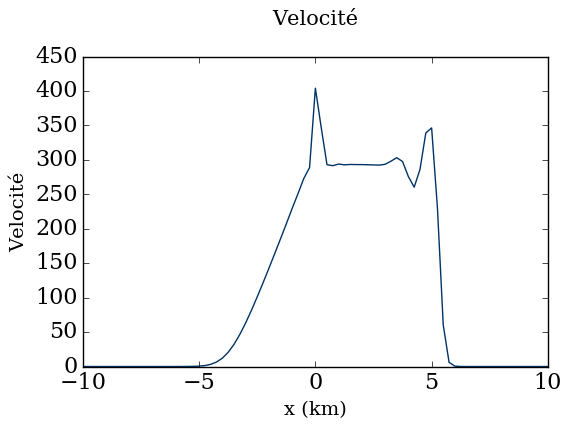

In [264]:
graph(plot(shock)[1],0.0,450.0,'Velocité')

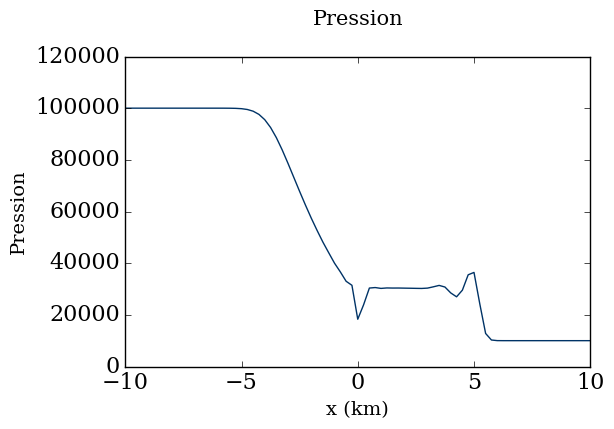

In [265]:
graph(plot(shock)[2],0.0,120000.0,'Pression')

In [266]:
ans(50,shock)

array([  3.74691403e-01,   2.92611472e+02,   3.02508902e+04])

### Lissage de la courbe et terme d'amortissement

Afin de pouvoir mieux comparer les graphiques obtenus à l'aide de la méthode de Richtmeyer à la solution idéale de Sod, nous nous intéressons aux pics localisés en plusieurs endroits de nos graphiques. L'apparition de ces pics est inhérente à l'utilisation de la formule de Richtmeyer. Elle ne correspond pas un comportement physique mais à des comportements liés aux défauts de la méthode elle-même. 

Après quelques recherches, nous trouvons l'existence d'une manière simple de "lisser" les graphes obtenus pour les rendre plus proches de la solution idéale par l'introduction d'un terme supplémentaire dans les formules de Richtmeyer. Par défaut, ce terme est nul dans la solution de base, mais on peut le rendre supérieur à zéro de manière à ajuster la courbe pour la rendre plus conforme à la solution réelle sans modifier la méthode utilisée.

Voici le terme d'amortissement : 
$\epsilon (\underline{\mathbf{u}}^{n}_{i+1} - 2\underline{\mathbf{u}}^{n}_{i} + \underline{\mathbf{u}}^{n}_{i-1})$
, où $\epsilon$ est le coefficient d'amortissement, nul par défaut et gardé positif sinon.

Ce terme apparait dans la seconde équation de la méthode, comme ceci :
$\underline{\mathbf{u}}^{n+1}_i = \underline{\mathbf{u}}^n_i - \frac{\Delta t}{\Delta x} \left(\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} - \underline{\mathbf{f}}^{n+\frac{1}{2}}_{i-\frac{1}{2}} \right) + \epsilon (\underline{\mathbf{u}}^{n}_{i+1} - 2\underline{\mathbf{u}}^{n}_{i} + \underline{\mathbf{u}}^{n}_{i-1})$

(voir : http://nbviewer.jupyter.org/github/barbagroup/PASI2013/blob/master/lessons/02_Sod.Shock.Tube.ipynb ,dans la partie 
##### "Richtmeyer method - damping")

- Créons une fonction appelée "Smooth", identique à la fonction "Shock", à l'exception de l'ajout d'un argument appelé "damp" correspondant au coefficient $\epsilon$, et du terme d'amortissement. L'utilisation de cette fonction, avec des valeurs de "damp" supérieures à zéro, nous permettra de lisser les courbes que nous avions obtenues plus tôt et de voir si elles correspondent bien à une approche de la solution analytique de Sod.

In [267]:
def Smooth(v0,nt,damp): #ajout de l'argument 'damp'.
    uu=v0.copy()
    predictor=numpy.zeros((3,80))
    for t in range(nt):
        
        vv=uu.copy()
        f=computef(uu)
        predictor[:,:]=0.5*(uu[:,1:]+uu[:,:-1])-0.5*dt/dx*(f[:,1:]-f[:,:-1])
        ff=computef(predictor)
        vv[:,1:-1]=uu[:,1:-1]-dt/dx*(ff[:,1:]-ff[:,:-1])+0.1* \
        + damp * (uu[:,2:] - 2*uu[:,1:-1] + uu[:,:-2]) #ajout du terme d'amortissement.
        
        uu=vv.copy()
        
    return uu

- Essayons avec un coefficient d'amortissement $\epsilon$ = 0.4 :

In [268]:
smooth = Smooth(v0,50,0.4)

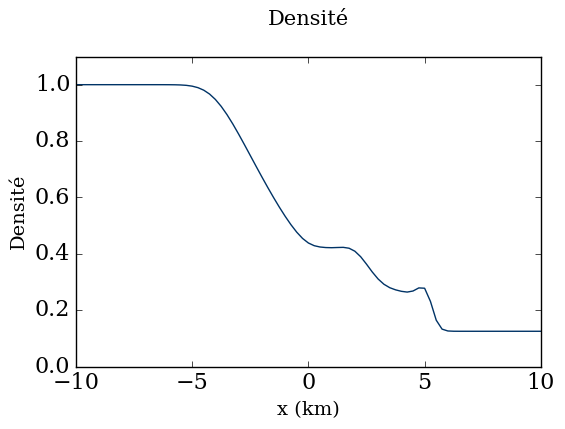

In [269]:
graph(plot(smooth)[0],0.0,1.1,'Densité')

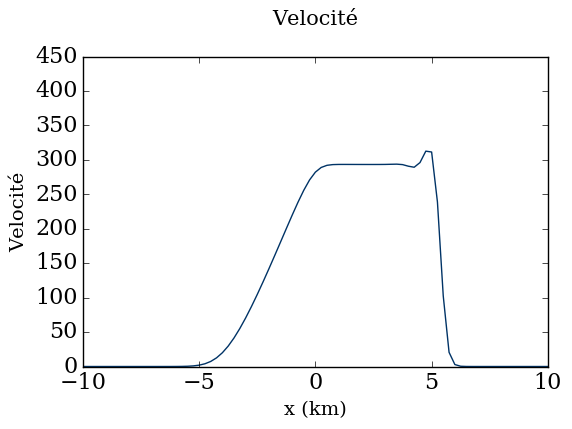

In [270]:
graph(plot(smooth)[1],0.0,450.0,'Velocité')

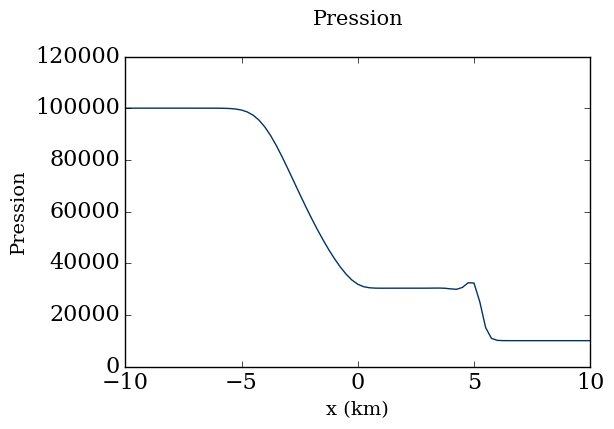

In [271]:
graph(plot(smooth)[2],0.0,120000.0,'Pression')

On remarque qu'on a gardé pour chaque variable (densité, vélocité, pression), une allure de graphique similaire à celle qu'on avait sans amortissement, mais que les pics gênants ont presque déserté les courbes.

Si on observe les courbes données dans la leçon et reprenant les solutions graphiques exactes, nous voyons que l'allure de nos courbes lissées correspond de manière satisfaisante au comportement attendu. 

### D'autres conditions initiales

Nous pouvons utiliser la méthode de Richtmeyer pour examiner une évolution dans une situation initiale différente.
Ici , nous prenons un tube de même longueur avec un gaz d'une densité et à une pression données séparé par deux parois d'épaisseur négligeable de deux compartiments à l'une et l'autre extrémité du tube contenant un gaz (identique dans les deux compartiments) d'une densité et à une pression supérieures.

Nous observerons l'évolution de la pression et de la densité dans le tube au cours du temps, pour un temps zéro correspondant à la suppression simultanée des parois.

- Posons les nouvelles conditions initiales NIC du problème :

In [310]:
NIC=numpy.zeros((3,nx))
NIC[0,:21]=1.0 #kg/m³
NIC[0,21:60]=0.125 #kg/m³
NIC[0,60:]=1.0 #kg/m³
NIC[1,0:]=0.0 #m/s
NIC[2,:21]=100000.0 #N/m²
NIC[2,21:60]=10000.0 #N/m²
NIC[2,60:]=100000.0 #N/m²

- La vitesse est nulle partout au temps t=0s. 
- Voyons à quoi ressemble la situation dans le tube à ce moment au niveau de la pression et de la densité :

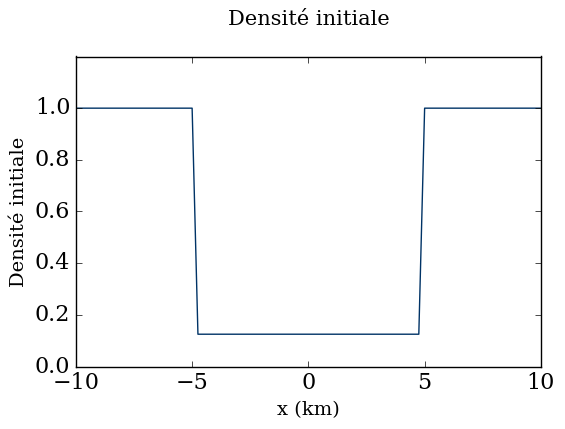

In [311]:
graph(NIC[0],0.0,1.2,'Densité initiale')

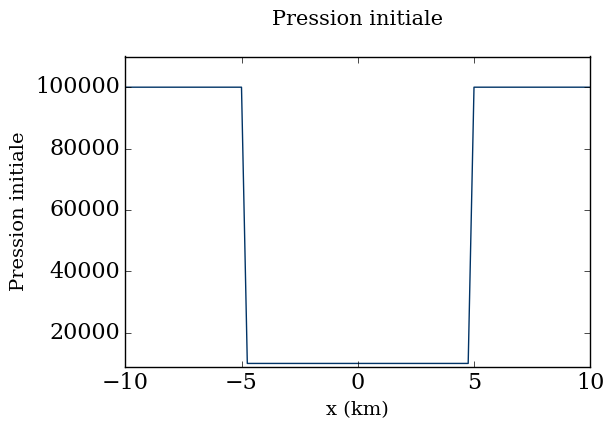

In [312]:
graph(NIC[2],9000.,110000.,'Pression initiale')

Nous appliquerons simplement la méthode de Richtmeyer (avec amortissement) à nos nouvelles conditions initiales.

#### Attention ! 
Nous devons avant tout imposer que le gaz du compartiment de droite a une vitesse négative (se dirige vers la gauche).
À des temps assez petits pour que le gaz du compartiment de droite n'ait pas encore atteint le centre du tube, nous pouvons simplement poser la condition que la vitesse est nulle dans la partie droite du tube en modifiant la fonction "ans":

In [313]:
def ans(j,vector):
    v=numpy.ones(3)
    v[0]=vector[0,j]
    
    #On impose la condition mentionnée plus haut :
    if j>(nx-1)/2 :
        v[1]=-(vector[1,j]/vector[0,j])
    else :
        v[1]=vector[1,j]/vector[0,j]

    v[2]=0.4*(vector[2,j]-0.5*vector[1,j]**2/vector[0,j])
    return v

- Nous regardons ce qu'il se passe à un temps petit. Voyons la situation à t=0,004s (après 20 pas de temps) :

In [314]:
v0=vector_u(NIC[0],NIC[1],NIC[2])
smooth = Smooth(v0,20,0.4)

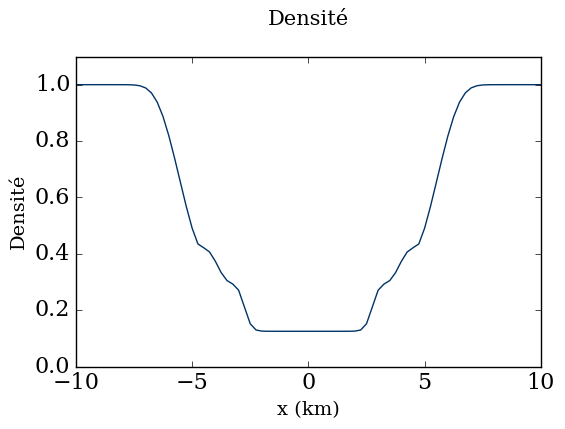

In [315]:
graph(plot(smooth)[0],0.0,1.1,'Densité')

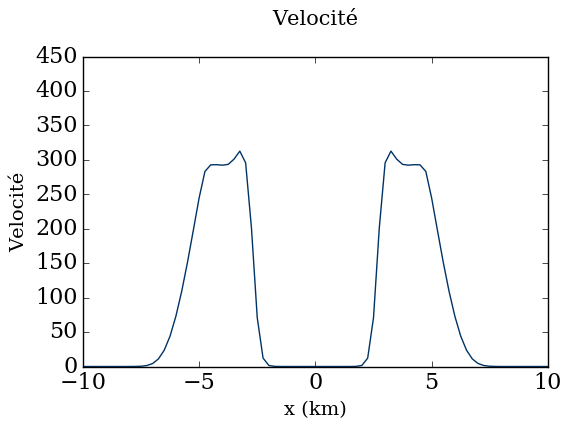

In [316]:
graph(plot(smooth)[1],0.0,450.0,'Velocité')

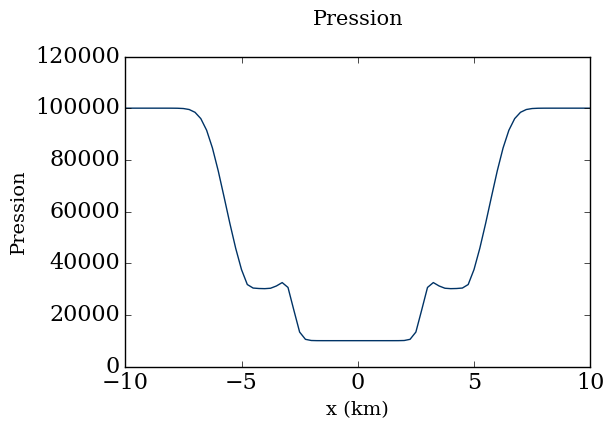

In [317]:
graph(plot(smooth)[2],0.0,120000.0,'Pression')

On a bien maintenant un comportement similaire des gaz à celui de la première situation, mais avec le gaz de plus haute densité se déplaçant de concert de part et d'autre du centre du tube vers la zone de gaz de plus faible densité.

- Regardons ce qu'on a après 0.01s (soit après 50 pas de temps) :

In [318]:
smooth = Smooth(v0,50,0.4)

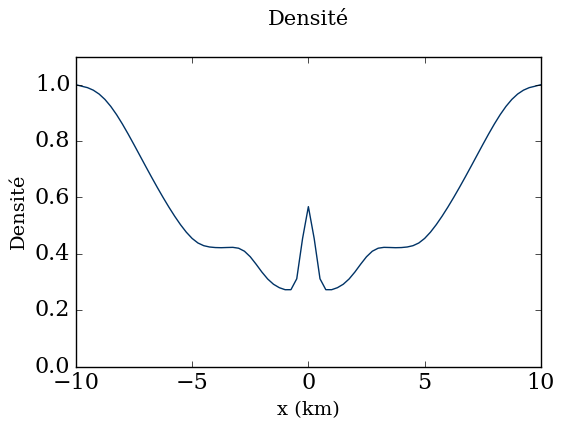

In [319]:
graph(plot(smooth)[0],0.0,1.1,'Densité')

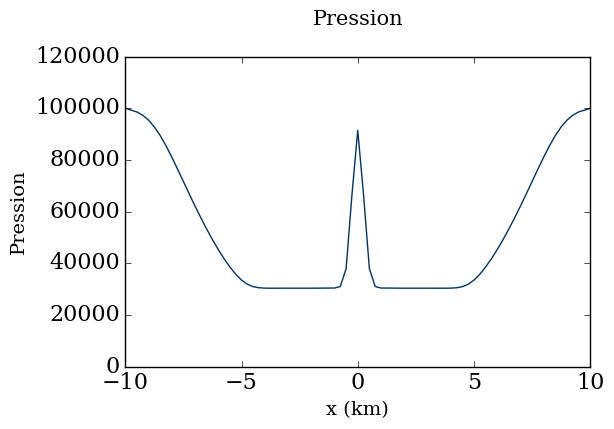

In [320]:
graph(plot(smooth)[2],0.0,120000.0,'Pression')

Les ondes correspondant à la densité et la pression ont commencé à interférer dès qu'elles ont atteint leur point de croisement (à peu près au centre du tube).

$\underline{Note}$ : nous ne pouvons plus aisément gérer la vélocité après un temps suffisamment grand pour que les gaz venant de la gauche et de la droite aient atteint leur point de rencontre. Voilà pourquoi nous nous intéressons ici uniquement à la pression et à la densité.

- Nous pouvons prolonger. Ici, en étendant à 70 pas de temps :

In [321]:
smooth = Smooth(v0,70,0.4)

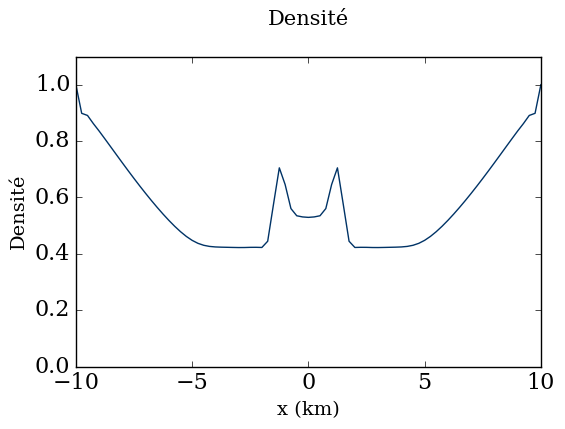

In [322]:
graph(plot(smooth)[0],0.0,1.1,'Densité')

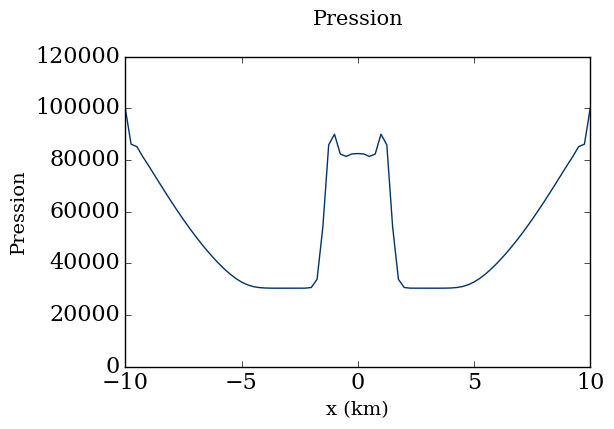

In [323]:
graph(plot(smooth)[2],0.0,120000.0,'Pression')